In [1]:
import os
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import pandas as pd
import cv2

from  torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
import torch
import torch.nn as nn

from torchvision import transforms as tt

In [2]:
'''
0 -> 2
1 -> 0
2 -> 1
3 -> 3
'''

gpu_number = 3
# device = torch.device(device=f'cuda:{gpu_number}')
device = torch.device('cuda')
device

device(type='cuda')

In [3]:
path_to_data = "D:/Desktop/abbyy/data/CourseOCRTask3" 

In [4]:
train_path = Path('/') / path_to_data / 'Train'
test_path = Path('/') / path_to_data / 'Test'

In [5]:
len(os.listdir(train_path / 'Images'))

6579

In [6]:
os.listdir(train_path)

['Images', 'Inverted', 'markup.csv', 'markup_wo_inverted.csv']

In [7]:
names = ['filename', 'number', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'code']
df = pd.read_csv(train_path / 'markup.csv', encoding='utf-16', header=None, names=names)

train_df = df[:5000]
val_df = df[5000:].reset_index()

In [8]:
class hw3dataset(Dataset):
    def __init__(self, df, path, device):
        self.device = device
        self.items = []
        self.transform = tt.Compose([
            tt.ToTensor(),
            tt.Resize((128, 128), tt.InterpolationMode.BICUBIC)
        ])
        
        for idx, row in tqdm(df.iterrows()):
            image_path = path / 'Images' / row['filename']
            if os.path.exists(image_path):
                img = np.array(Image.open(image_path)) / 255.
                vertices = np.array([[row['x1'], row['y1']], [row['x2'], row['y2']], [row['x3'], row['y3']], [row['x4'], row['y4']]])
                mask = cv2.fillConvexPoly(np.zeros(img.shape[:2]), vertices, (1,))[..., np.newaxis]
                img = self.transform(img).type(torch.float)
                mask = self.transform(mask).type(torch.float)
                self.items.append((img, mask))
#             if idx == 50:
#                 break
            
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        img, mask = self.items[idx]
        return img.to(self.device), mask.to(self.device)
#         return torch.tensor(img.transpose(2, 0, 1), dtype=torch.float, device=device),\
#                 torch.tensor(mask, dtype=torch.float, device=device)

In [9]:
train_data = hw3dataset(train_df, train_path, device)
val_data = hw3dataset(val_df, train_path, device)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [10]:
batch_size=1
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [11]:
# model from hw1

class enc_conv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.block(x)
    
class upsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.dec_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, u, e):
        u = self.upsample(u)
        pad_w = e.shape[2] - u.shape[2]
        pad_h = e.shape[3] - u.shape[3]
        padding = [pad_h // 2, pad_h - pad_h // 2, pad_w // 2, pad_w - pad_w // 2]
        u = nn.functional.pad(u, padding)
        return self.dec_conv(torch.cat((e, u), dim=1))
    
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
        self.enc_conv0 = enc_conv_block(3, 64)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = enc_conv_block(64, 128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = enc_conv_block(128, 256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = enc_conv_block(256, 512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = enc_conv_block(512, 1024)

        # decode
        self.up_0 = upsample_block(1024+512, 512)
        self.up_1 = upsample_block(512+256, 256)
        self.up_2 = upsample_block(256+128, 128)
        self.up_3 = upsample_block(128+64, 64)
        
        self.out = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3)) 

        # decoder
        u0 = self.up_0(b, e3)
        u1 = self.up_1(u0, e2)
        u2 = self.up_2(u1, e1)
        u3 = self.up_3(u2, e0)
        
        out = self.out(u3)
        return out
unet_model = UNet().to(device)

In [12]:
from time import time
from IPython.display import clear_output

In [13]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in tqdm(data_tr):

            opt.zero_grad()
            Y_pred = model(X_batch)
            Y_pred = torch.sigmoid(Y_pred)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()
            avg_loss += loss.item() / len(data_tr)
            del X_batch
            del Y_batch
        toc = time()
        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss)
        
        model.eval()
        Y_hat = model(X_val.to(device)).detach().cpu()

        val_loss_sum = 0
        for X_val_batch, Y_val_batch in tqdm(data_val):
            with torch.set_grad_enabled(False):
                Y_pred_batch = model(X_val_batch)
                loss = loss_fn(torch.sigmoid(Y_pred_batch), Y_val_batch)
                prediction = torch.sigmoid(Y_pred_batch) > 0.5
            val_loss_sum += loss.item()
        val_loss.append((val_loss_sum/len(data_val)))

        clear_output(wait=True)
        plt.figure(figsize = (16, 7))
        plt.title('Loss')
        plt.plot(train_loss, label='train loss')
        plt.plot(val_loss, label='val loss')
        plt.legend()
        plt.show()

        print(len(X_val))
        for k in range(1):
            plt.subplot(2, 1, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 1, k+2)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f'epoch{epoch}.pth')

    return train_loss, val_loss

1


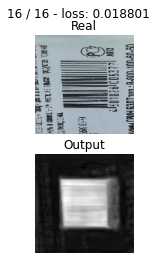

In [14]:
unet_train_loss, unet_val_loss = train(unet_model, torch.optim.Adam(unet_model.parameters()), nn.BCELoss(), 16, train_dl, val_dl)

In [151]:
torch.save(unet_model.state_dict(), f'final_model.pth')

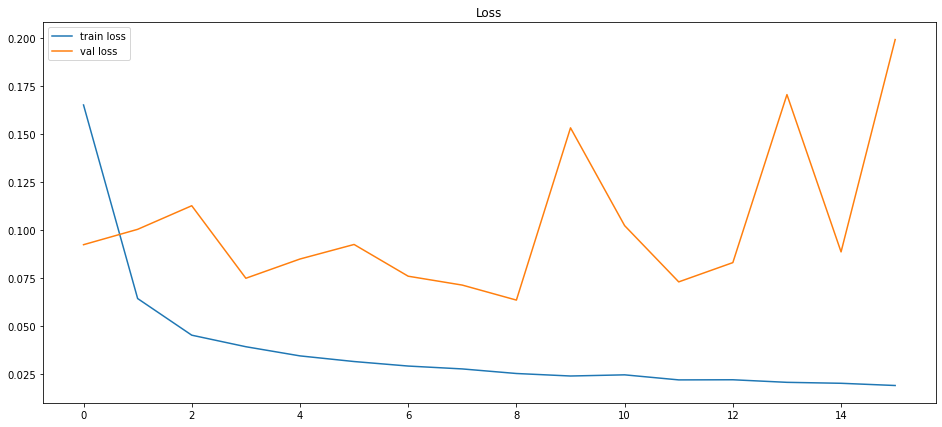

In [15]:
plt.figure(figsize = (16, 7))
plt.title('Loss')
plt.plot(unet_train_loss, label='train loss')
plt.plot(unet_val_loss, label='val loss')
plt.legend()
plt.show()

In [22]:
for idx, row in train_df.iterrows():
    if os.path.exists(train_path / 'Images' / row['filename']):
        break

In [23]:
image_path = train_path / 'Images' / row['filename']

In [24]:
img = np.array(Image.open(image_path)) / 255.
vertices = np.array([[row['x1'], row['y1']], [row['x2'], row['y2']], [row['x3'], row['y3']], [row['x4'], row['y4']]])
mask = cv2.fillConvexPoly(np.zeros(img.shape[:2]), vertices, (1,))[..., np.newaxis]

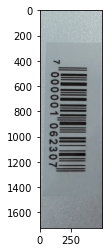

In [26]:
plt.imshow(img)

In [29]:
shape = img.shape
shape

(1724, 496, 3)

In [42]:
transform = tt.Compose([
            tt.ToTensor(),
            tt.Resize((128, 128), tt.InterpolationMode.BICUBIC)
        ])

In [43]:
out = unet_model(transform(img).unsqueeze(0).type(torch.float).to(device))

In [105]:
out.shape

torch.Size([1, 1, 128, 128])

In [72]:
mask_np = (torch.sigmoid(out.squeeze()) > 0.5).cpu().detach().numpy()

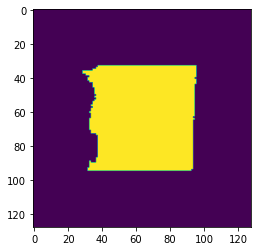

In [46]:
plt.imshow(mask_np)

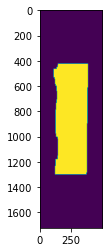

In [57]:
mask_resized = tt.Compose([
            tt.ToTensor(),
            tt.Resize(img.shape[:2], tt.InterpolationMode.BICUBIC)
        ])(mask_np)[0]
plt.imshow(mask_resized)

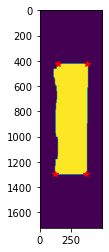

In [59]:
nonzero = mask_resized.nonzero()
sums = nonzero.sum(axis=1)
top_left = nonzero[sums.argmin()]
bottom_right = nonzero[sums.argmax()]
diffs = nonzero[:, 0] - nonzero[:, 1]
top_right = nonzero[diffs.argmin()]
bottom_left = nonzero[diffs.argmax()]

plt.imshow(mask_resized)
plt.plot(top_left[1], top_left[0], 'r*')
plt.plot(bottom_right[1], bottom_right[0], 'r*')

plt.plot(top_right[1], top_right[0], 'r*')
plt.plot(bottom_left[1], bottom_left[0], 'r*')

In [134]:
def get_vertices(prediction):
    mask = torch.sigmoid(prediction.cpu().detach()) > 0.5
    nonzero = mask.nonzero()
    sums = nonzero.sum(axis=1)
    top_left = nonzero[sums.argmin()]
    bottom_right = nonzero[sums.argmax()]
    diffs = nonzero[:, 0] - nonzero[:, 1]
    top_right = nonzero[diffs.argmin()]
    bottom_left = nonzero[diffs.argmax()]
    return torch.stack([top_left, top_right, bottom_right, bottom_left]).numpy().astype(int)

In [135]:
transform = tt.Compose([
            tt.ToTensor(),
            tt.Resize((128, 128), tt.InterpolationMode.BICUBIC)
        ])

In [163]:
unet_model.load_state_dict(torch.load('epoch10.pth')) # Эпоха с наимешьим val loss

<All keys matched successfully>

In [164]:
answer = pd.DataFrame()
for image_file in tqdm(os.listdir(test_path / 'Images')):
    image = np.array(Image.open(test_path / 'Images' / image_file)) / 255.
    out = unet_model(transform(image).unsqueeze(0).type(torch.float).to(device))
    out_resized = tt.Compose([
            tt.Resize(image.shape[:2], tt.InterpolationMode.BICUBIC)
        ])(out).squeeze()
    vertices = get_vertices(out_resized)
#     for vertex in vertices:
#         plt.plot(vertex[1], vertex[0], 'r*')
    answer = answer.append([[
        image_file,
        0,
        vertices[3][1], vertices[3][0],
        vertices[0][1], vertices[0][0],
        vertices[1][1], vertices[1][0],
        vertices[2][1], vertices[2][0],
        0        
    ]])
answer

  0%|          | 0/100 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10
0,00f3d3d8b60ef559304ff51cadaf4fb1.png,0,431,1962,434,650,1261,664,1267,1936,0
0,021e9179bdd3287d873de5208535b4a7.png,0,732,930,743,324,2182,362,2197,902,0
0,065c4a67725752b09302b0a6a5ad3971.png,0,962,1075,840,357,2372,130,2514,831,0
0,099574d0f797fe2519686fd1e724ebf3.png,0,195,343,236,134,714,129,736,324,0
0,10c9065a00b9bea9b741208b2679cf76.png,0,672,1539,780,573,2271,766,2190,1582,0
...,...,...,...,...,...,...,...,...,...,...,...
0,f534d421c7e36d6133a5e9031a7e2dd5.png,0,259,1972,482,97,600,94,647,1975,0
0,f7c811258e32c7150ff454bf419e8bc7.png,0,82,105,76,48,224,37,223,95,0
0,f9bf5d96a0cf5d64aac4eb5806554224.png,0,626,1136,682,453,1811,524,1741,1161,0
0,fedcc45b69bb6c40c4599bbb499ee365.png,0,359,491,363,189,1047,174,1053,506,0


In [165]:
answer.to_csv('answer.csv', header=False, index=False, encoding='utf-16')

In [166]:
pd.read_csv('answer.csv', header=None, encoding='utf-16')

,0,1,2,3,4,5,6,7,8,9,10
0,00f3d3d8b60ef559304ff51cadaf4fb1.png,0,431,1962,434,650,1261,664,1267,1936,0
1,021e9179bdd3287d873de5208535b4a7.png,0,732,930,743,324,2182,362,2197,902,0
2,065c4a67725752b09302b0a6a5ad3971.png,0,962,1075,840,357,2372,130,2514,831,0
3,099574d0f797fe2519686fd1e724ebf3.png,0,195,343,236,134,714,129,736,324,0
4,10c9065a00b9bea9b741208b2679cf76.png,0,672,1539,780,573,2271,766,2190,1582,0
...,...,...,...,...,...,...,...,...,...,...,...
95,f534d421c7e36d6133a5e9031a7e2dd5.png,0,259,1972,482,97,600,94,647,1975,0
96,f7c811258e32c7150ff454bf419e8bc7.png,0,82,105,76,48,224,37,223,95,0
97,f9bf5d96a0cf5d64aac4eb5806554224.png,0,626,1136,682,453,1811,524,1741,1161,0
98,fedcc45b69bb6c40c4599bbb499ee365.png,0,359,491,363,189,1047,174,1053,506,0


In [167]:
import csv
def read_file(path):
	markup = {}
	with open(path, 'r', encoding='utf-16') as fd:
		rd = csv.reader(fd)
		for row in rd:
			id = row[0]
			value = row[1]
			points = [(int(row[i]), int(row[i + 1])) for i in range(2, 10, 2)]
			markup[id] = [value, points]
	return markup

In [168]:
from shapely.geometry import Polygon

In [169]:
def calculate_detection_result(markup, answer):
	well_detected = 0
	IOU_THRESHOLD = 0.5
	for (k, v) in answer.items():
		a = Polygon(v[1])
		b = Polygon(markup[k][1])
		iou = a.intersection(b).area / a.union(b).area
		if iou > IOU_THRESHOLD:
			well_detected += 1
	return well_detected / len(markup)

In [170]:
def calculate_accuracy(markup, answer):
	counter = 0
	for (k, v) in answer.items():
		markup_value = markup[k][0]
		if markup_value == v[0]:
			counter += 1
	return counter / len(markup)

In [171]:
gt_path = os.path.join("markup.csv")
answer_path = os.path.join("answer.csv")
print(f"Checking answer ({answer_path}) against markup({gt_path})")
markup = read_file(gt_path)
answer = read_file(answer_path)
recognition_accuracy = calculate_accuracy(markup, answer)
print(f"recognition_accuracy={recognition_accuracy}")
detection_result = calculate_detection_result(markup, answer)
print(f"detection_result={detection_result}")

Checking answer (answer.csv) against markup(markup.csv)
recognition_accuracy=0.0
detection_result=0.99


Комментарий про решение

На студенческом сервере все забито, поэтому обучался на домашнем гпу

Использовал достаточно жесткий ресайз до 128х128, иначе не проходил по памяти

Для iou 0.5 оно все равно сработало на удивление отлично